In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import operator

In [2]:
input_df = pd.read_csv("data/predictions_algo_verbose_big_cv_name.csv")
perf_df = pd.read_csv("data/perf_summary.csv",index_col=0)

In [3]:
unique_exp = list(set(input_df["experiment"]))
unique_algo = list(set(input_df["algo"]))

In [4]:
range_thresholds = np.arange(0,0.1,0.05)
np.append(range_thresholds,(0.5))
unique_algo

['LASSO', 'BRR', 'ANN', 'RF', 'SVR', 'AB', 'GB']

Analyzing the following dataset: Beck


c:\users\asus\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Analyzing the following dataset: MTBLS38
Analyzing the following dataset: MTBLS87
Analyzing the following dataset: Krauss_21
Analyzing the following dataset: Tohge
Analyzing the following dataset: MTBLS20
Analyzing the following dataset: Otto
Analyzing the following dataset: Stravs_22
Analyzing the following dataset: LIFE_old
Analyzing the following dataset: FEM_orbitrap_plasma
Analyzing the following dataset: UniToyama_Atlantis
Analyzing the following dataset: Toshimitsu
Analyzing the following dataset: Mark
Analyzing the following dataset: Ales_18
Analyzing the following dataset: FEM_orbitrap_urine
Analyzing the following dataset: Takahashi
Analyzing the following dataset: MTBLS36
Analyzing the following dataset: Eawag_XBridgeC18
Analyzing the following dataset: Taguchi_12
Analyzing the following dataset: Cao_HILIC
Analyzing the following dataset: LIFE_new
Analyzing the following dataset: FEM_lipids
Analyzing the following dataset: Krauss
Analyzing the following dataset: RIKEN
Analyz

c:\users\asus\appdata\local\conda\conda\envs\py36\lib\site-packages\matplotlib\legend.py:936: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000002637501AF98>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


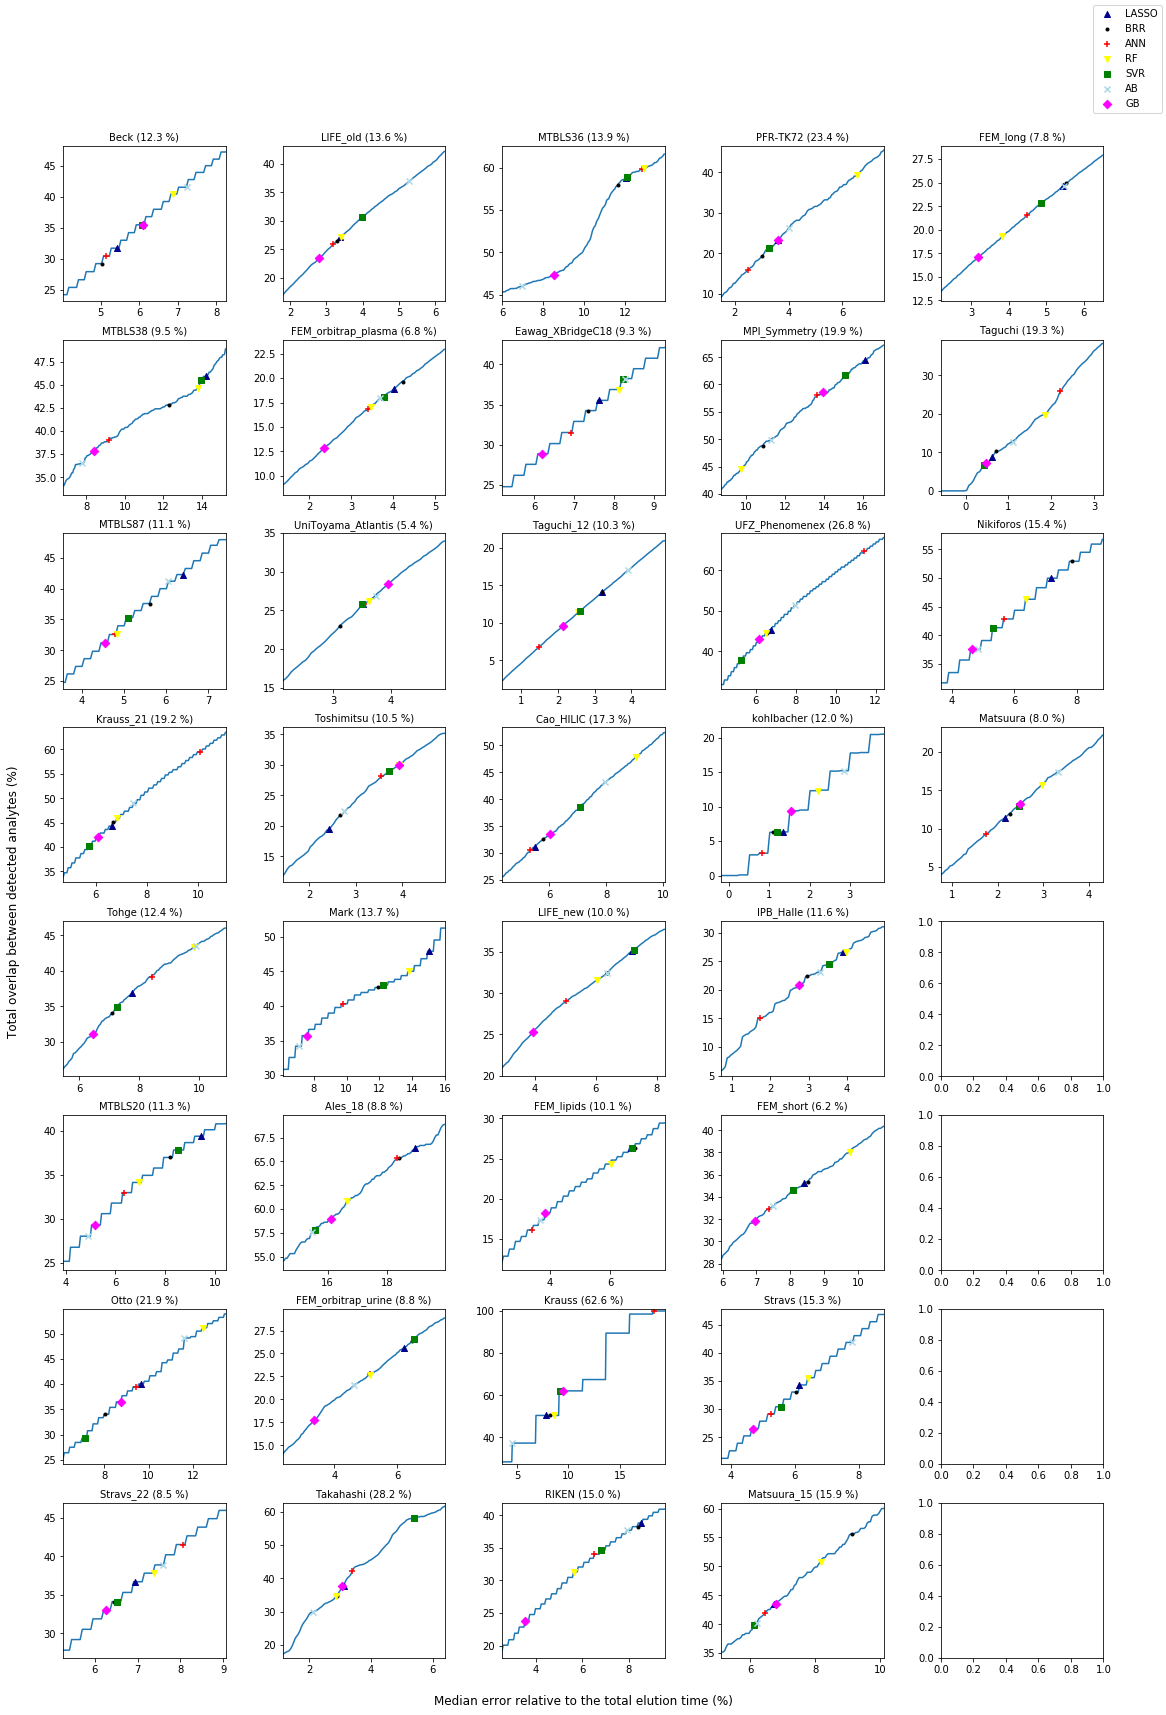

In [6]:
row_plot = 0
col_plot = 0

num_row_plot = 7
num_col_plot = 4

algo_cols = {
    "GB" : "magenta",
    "SVR": "green",
    "RF": "yellow",
    "BRR": "black",
    "ANN": "red",
    "AB": "lightblue",
    "LASSO": "darkblue"
}

algo_marker = {
    "GB" : "D",
    "SVR": "s",
    "RF": "v",
    "BRR": ".",
    "ANN": "+",
    "AB": "x",
    "LASSO": "^"
}

diff_axis = 1.0

f, axarr = plt.subplots(num_row_plot+1, num_col_plot+1,figsize=(17,25))

for ue in unique_exp:
    print("Analyzing the following dataset: %s" % (ue))
    range_thresholds = np.arange(min(perf_df.loc[ue,])-diff_axis,max(perf_df.loc[ue,])+diff_axis,0.05)
    range_thresholds = np.append(range_thresholds,(100.0))
    df_slice = input_df[input_df["experiment"] == ue]
    for algo in ["GB"]:
        tot_overlap = set()
        overlap_seq = []
        legend_obj = []
        legend_names = []
        
        df_slice_algo = df_slice[df_slice["algo"] == algo]
        df_slice_algo["tr_normalized"] = (df_slice_algo["tr"]/max(df_slice_algo["tr"]))*100
        
        for threshold in range_thresholds:
            for row_index,row_series in df_slice_algo.iterrows():
                min_sel_mol = row_series["tr_normalized"]-threshold
                max_sel_mol = row_series["tr_normalized"]+threshold
                mol1 = row_series["identifier"]
                for mol2 in df_slice_algo[(min_sel_mol < df_slice_algo["tr_normalized"]+threshold) \
                                          & (max_sel_mol > df_slice_algo["tr_normalized"]+threshold)]["identifier"]:
                    if mol1 == mol2: continue
                    if "%s|%s" % (mol1,mol2) not in tot_overlap:
                        tot_overlap.add("%s|%s" % (mol1,mol2))
                        tot_overlap.add("%s|%s" % (mol2,mol1))
                for mol2 in df_slice_algo[(max_sel_mol > df_slice_algo["tr_normalized"]-threshold) \
                                          & (min_sel_mol < df_slice_algo["tr_normalized"]-threshold)]["identifier"]:
                    if mol1 == mol2: continue
                    if "%s|%s" % (mol1,mol2) not in tot_overlap:
                        tot_overlap.add("%s|%s" % (mol1,mol2))
                        tot_overlap.add("%s|%s" % (mol2,mol1))
                #tot_overlap += len(df_slice_algo[(min_sel_mol > df_slice_algo["tr_normalized"]-threshold) & (max_sel_mol > df_slice_algo["tr_normalized"]+threshold)].index)
            overlap_seq.append(len(tot_overlap))
        legend_obj.append(axarr[row_plot,col_plot].plot(range_thresholds,[(ovs/max(overlap_seq))*100 for ovs in overlap_seq],zorder=1,label="Overlapping analytes"))
        legend_names.append("Overlapping analytes")
        
        diff_algos = []
        
        for ua in unique_algo:
            diff_sel_range = map(abs,(perf_df.loc[ue,ua])-range_thresholds)
            min_index, min_value = min(enumerate(diff_sel_range), key=operator.itemgetter(1))
            legend_obj.append(axarr[row_plot,col_plot].scatter(perf_df.loc[ue,ua],(overlap_seq[min_index]/max(overlap_seq))*100,
                                            marker=algo_marker[ua],c=algo_cols[ua],zorder=2,label=ua))
            legend_names.append(ua)
            diff_algos.append((overlap_seq[min_index]/max(overlap_seq))*100)
            
            
            #axarr[row_plot,col_plot].axvline(perf_df.loc[ue,ua]/100,linewidth=1,alpha=1.0,linestyle="--",c=algo_cols[ua])
        axarr[row_plot,col_plot].set_title("%s (%s %s)" % (ue,round(max(diff_algos)-min(diff_algos),1),"%"), fontsize="medium")
                
        min_x_val = min(perf_df.loc[ue,])-diff_axis
        max_x_val = max(perf_df.loc[ue,])+diff_axis

        min_y_val = min([(ovs/max(overlap_seq))*100 for rt,ovs in zip(range_thresholds,overlap_seq) if rt >= min_x_val and rt <= max_x_val])-diff_axis
        max_y_val = max([(ovs/max(overlap_seq))*100 for rt,ovs in zip(range_thresholds,overlap_seq) if rt >= min_x_val and rt <= max_x_val])+diff_axis

        axarr[row_plot,col_plot].set_xlim([min_x_val,max_x_val])
        axarr[row_plot,col_plot].set_ylim([min_y_val,max_y_val])
        
        if row_plot == num_row_plot:
            row_plot = 0
            col_plot += 1
        else: row_plot += 1

f.legend(legend_obj,legend_names)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("Median error relative to the total elution time (%)", labelpad=20, fontsize="large")
plt.ylabel("Total overlap between detected analytes (%)", labelpad=20, fontsize="large")
plt.savefig("overlap_error_fig.eps", format='eps', dpi=1000)
plt.show()

In [8]:
time_long_df = pd.read_csv("data/time_algos.csv")

In [9]:
time_wide_df = time_long_df.pivot(index="Dataset", columns="Algorithm", values="Time")

In [10]:
time_wide_df.loc["Average"] = time_wide_df.mean()

In [11]:
time_wide_df.round(1)

Algorithm,ANN,AdaBoost,BRR,LASSO,RF,SVR,XGB
Dataset,,,,,,,
Ales_18,27.7,39.7,14.5,4.8,46.1,11.4,115.7
Beck,42.0,67.5,17.6,4.8,50.1,115.6,288.1
Cao_HILIC,24.1,51.5,17.0,4.4,47.3,13.2,110.6
Eawag_XBridgeC18,42.7,87.4,16.4,4.6,57.0,123.8,278.2
FEM_lipids,23.6,45.6,14.3,4.3,45.6,11.1,73.0
FEM_long,55.6,64.3,17.3,7.1,54.0,100.1,356.8
FEM_orbitrap_plasma,26.3,31.8,14.3,6.2,48.5,12.5,111.4
FEM_orbitrap_urine,26.0,48.2,14.5,4.6,45.7,12.3,128.8
FEM_short,23.5,45.6,14.0,4.5,42.1,11.3,74.9


In [12]:
train_df = pd.read_csv("data/predictions_algo_verbose_big_cv_train.csv")

In [13]:
import statistics
from scipy.stats import pearsonr

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',c="black", linewidth=1.0,alpha=0.5)

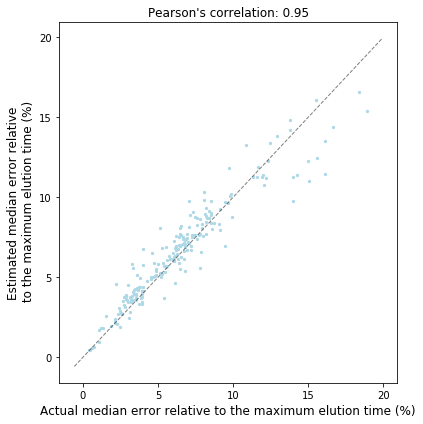

In [14]:
plt.figure(figsize=(6,6))
test_perf = []
train_perf = []

for ue in unique_exp:
    for algo in unique_algo:
        if algo == "LASSO": new_algo = "lasso"
        if algo == "BRR": new_algo = "bayesianregr"
        if algo == "AB": new_algo = "adaboost"
        if algo == "GB": new_algo = "xgb"
        if algo == "SVR": new_algo = "SVM"
        if algo == "ANN": new_algo = "MLP"
        if algo == "RF": new_algo = "RF"
        if algo == "ANN": continue
        train_df_slice = train_df[train_df["experiment"] == ue]

        train_df_slice = train_df_slice[train_df_slice["algo"] == new_algo]
        train_df_slice["tr_norm"] = (abs(train_df_slice["tr"]-train_df_slice["pred"])/max(train_df_slice["tr"]))*100

        plt.scatter(perf_df.loc[ue,algo],statistics.median(train_df_slice["tr_norm"]),c="lightblue",s=5)
        
        test_perf.append(perf_df.loc[ue,algo])
        train_perf.append(statistics.median(train_df_slice["tr_norm"]))

plt.title("Pearson's correlation: %s" % (round(pearsonr(test_perf,train_perf)[0],3)),fontsize="large")
plt.ylabel("Estimated median error relative\n to the maximum elution time (%)", fontsize="large")
plt.xlabel("Actual median error relative to the maximum elution time (%)", fontsize="large")
abline(1.0,0.0)        

plt.tight_layout()
plt.savefig("error_estimation.eps", format='eps', dpi=1000)
plt.show()